# Compare the screen values of individual sgRNAs or CREs versus the qPCR results of individual sgRNA validations

Do the bulk CRISPR screen results correlate with the individual sgRNA results? Do the validations support the screens?

### Load packages

In [49]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ggpubr))
# suppressPackageStartupMessages(library(rcompanion))

### Load qPCR data for individual sgRNA validations

#### Tycko 2019, GATA1

PMID: 31492858

In [50]:
tycko <- read.delim("suppfigure2/qpcr_data/tycko.gata1validationvsscreen.qpcr.txt", header = TRUE)
head(tycko,n=1)

,label,guide,name,Avg.Guide.Enrichment,avg.biorep,protospacer,grna_id,type,d7.vs.plasmid.log2FoldChange,d21.vs.plasmid.log2FoldChange,chrom,pam_start,pam_end,strand,length,grna_start,grna_end
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>
1,GATA1_chrX:48659761-48659780:-_--_29309,GTGTGGCTGGGCCGAGAGCG,eHDAC6,-4.47752,0.115,TGTGGCTGGGCCGAGAGCG,chrX:48801351-48801354,tiling,-0.5227462,-4.43329,chrX,48801351,48801354,-,19,48801355,48801373


#### Reilly 2021, FADS1/3

PMID: 34326544

In [51]:
reilly1<- read.delim("suppfigure2/qpcr_data/sabeti.fads1.qpcr.longformat.txt", header = TRUE)
head(reilly1,n=1)

,name,CRE_activity_summit,qpcr,group,grna_id
,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,RAND-2_NT,0,1.215964,NT,RAND-2_NT


In [52]:
reilly2 <- read.delim("suppfigure2/qpcr_data/sabeti.fads3.qpcr.longformat.txt", header = TRUE)
head(reilly2,n=1)

,name,CRE_activity_summit,CRE_name,qpcr,group,grna_id
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,RAND-2_NT,0,NA,1.306876,NT,RAND-2_NT


For these experiments I need to add the sgRNA information, so load results of peak calling with DESeq2 that contain the sgRNA metadata.

In [53]:
# reilly_grna <- read_tsv("suppfigure2/qpcr_data/SabetiHCRFlowFISH_FADS1_deseq2.results.withcoords.tsv", show_col_types = FALSE)
# head(reilly_grna,n=1)

#### Klann, 2021

doi: https://doi.org/10.1101/2021.03.08.434470

In [54]:
klann <- read.delim("suppfigure2/qpcr_data/klann.qpcrvsscreen.validationscreen.txt", header = TRUE)
head(klann,n=1)

,qpcr_target,dhs,qpcr_treatment,guideID,qpcr_avg_fc,qpcr_sem,group,DHS,protospacer,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,type
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LMO2,chr11.1735,chr11.1735.21,chr11.1735.21,0.1642146,0.002634097,depleted,chr11.1735,TAACTGTTACATGAAGACAA,197.1499,-4.187824,0.3369117,-12.85244,8.333521e-38,5.184449e-34,targeting


#### Various FlowFISH experiment data from Fulco et. al 2016 and 2019

PMID: 27708057, PMID: 31784727, and provided by Benjamin Doughty (now at Stanford)

In [55]:
doughty <- read.delim("suppfigure2/qpcr_data/doughty_qpcr_ff.txt", header = TRUE)
head(doughty,n=1)

,name,qPCR,FF
,<chr>,<dbl>,<dbl>
1,GATA1 TSS->GATA1,0.09,0.22


### Generate df with cleaned qPCR results

#### Reilly

In [56]:
reilly_final <-
  reilly1 %>%
  mutate(qpcr_target = "FADS1") %>%
  bind_rows(reilly2 %>% select(-CRE_name) %>% mutate(qpcr_target = "FADS3")) %>%
  rename("grna_type" = group,
         "screen_value" = CRE_activity_summit) %>%
  mutate(experiment = "SabetiFADS") %>%
  rename(grna = grna_id) %>%
  select(experiment, grna, qpcr_target, screen_value, qpcr, grna_type) %>%
  distinct() %>%
  group_by(grna, qpcr_target) %>%
  mutate(screen_value = max(screen_value)) %>%
 distinct()

head(reilly_final,n=1)

experiment,grna,qpcr_target,screen_value,qpcr,grna_type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
SabetiFADS,RAND-2_NT,FADS1,0,1.215964,NT


#### Klann

In [57]:
klann_final <- 
  klann %>%
  mutate(experiment = "KlannValidation",
         screen_value = log2FoldChange,
         grna = guideID,
         qpcr = qpcr_avg_fc,
         grna_type = type) %>%
  select(experiment, grna, qpcr_target, screen_value, qpcr, grna_type)

head(klann_final,n=1)

,experiment,grna,qpcr_target,screen_value,qpcr,grna_type
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,KlannValidation,chr11.1735.21,LMO2,-4.187824,0.1642146,targeting


#### Tycko

In [58]:
tycko_final <-
  tycko %>%
  mutate(experiment = "TyckoGATA1",
         grna = label,
         qpcr_target = "GATA1",
         screen_value = Avg.Guide.Enrichment,
         log2FoldChange = d21.vs.plasmid.log2FoldChange,
         qpcr = avg.biorep,
         grna_type = ifelse(grepl("TSS", name), "TSS", ifelse(grepl("Safe", name), "NT", "targeting"))
  ) %>%
  select(experiment, grna, qpcr_target, screen_value, qpcr, grna_type)

head(tycko_final,n=1)

,experiment,grna,qpcr_target,screen_value,qpcr,grna_type
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,TyckoGATA1,GATA1_chrX:48659761-48659780:-_--_29309,GATA1,-4.47752,0.115,targeting


#### Doughty

In [59]:
doughty_final <-
  doughty  %>%
  filter(!is.na(qPCR) & !is.na(FF)) %>%
  mutate(grna_type = ifelse(grepl("TSS", name), "TSS", "targeting"),
         qpcr = qPCR,
         screen_value = FF) %>%
  separate(name, into = c("grna","qpcr_target"), sep = "->", remove = FALSE) %>%
  separate(grna, into = c("col1","col2"), sep = " ", remove = FALSE) %>%
  mutate(grna = ifelse(!is.na(col2), paste0(col1,"_",col2), paste0(col1)),
         experiment = "DoughtyFF",
         log2FoldChange = NA) %>% 
  select(experiment, grna, qpcr_target, screen_value, qpcr, grna_type)

head(doughty_final,n=1)

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 6 rows [4, 5, 9, 10, 11, 12].”


,experiment,grna,qpcr_target,screen_value,qpcr,grna_type
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,DoughtyFF,GATA1_TSS,GATA1,0.22,0.09,TSS


#### Combine into one df

In [60]:
final_qpcr <- 
  reilly_final %>%
  bind_rows(klann_final) %>%
  bind_rows(tycko_final) %>%
  bind_rows(doughty_final)

head(final_qpcr,n=1)
tail(final_qpcr,n=1)

experiment,grna,qpcr_target,screen_value,qpcr,grna_type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
SabetiFADS,RAND-2_NT,FADS1,0,1.215964,NT


experiment,grna,qpcr_target,screen_value,qpcr,grna_type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
DoughtyFF,HNRNPA1_TSS,NFE2,1.055447,1.41,TSS


### Visualize individual sgRNA qPCR results vs screen results

#### All GATA1

Warning message:
“Removed 1 rows containing missing values (geom_point).”


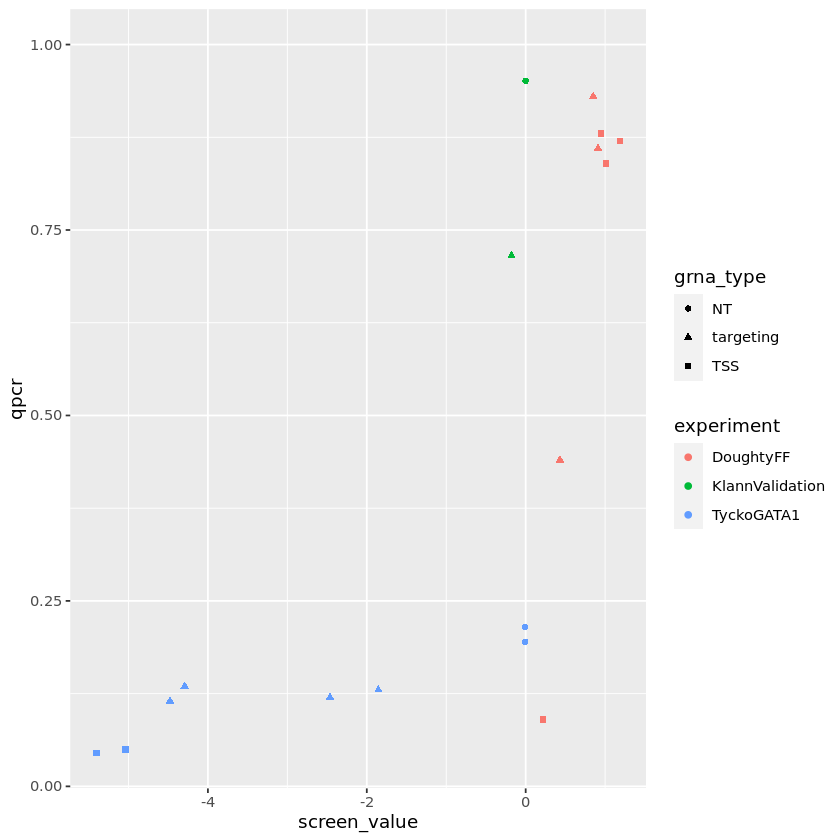

In [61]:
final_qpcr %>%
  filter(qpcr_target == "GATA1") %>%
  distinct() %>%
  ggplot(aes(x = screen_value, y = qpcr, color = experiment, shape = grna_type)) +
  geom_point() 

#### Filter genes, color by experiment, facet by experiment

Warning message:
“Removed 3 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


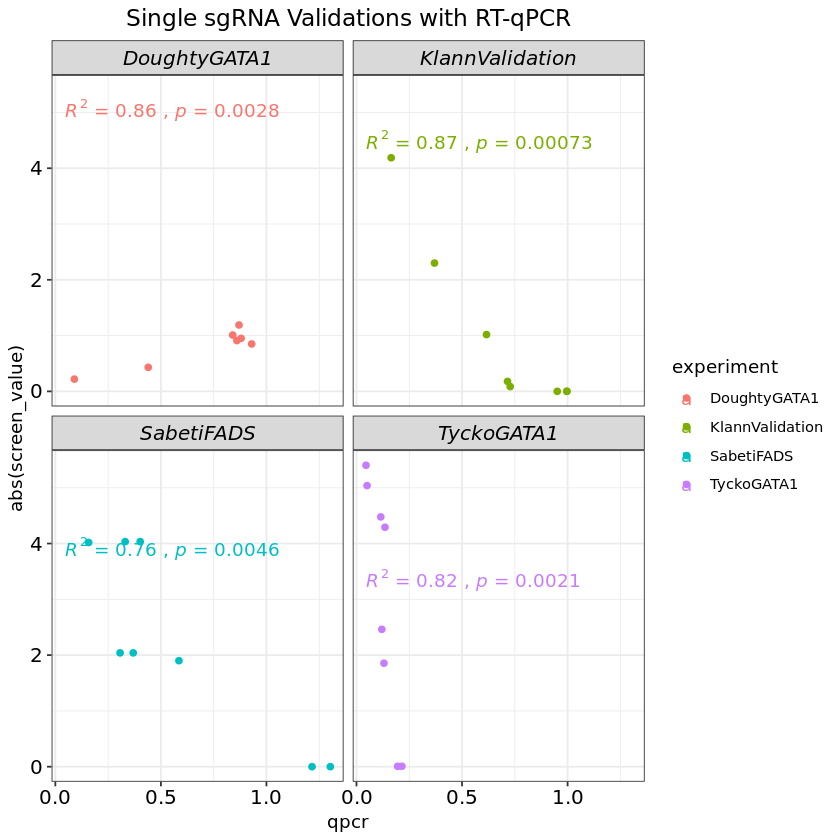

In [62]:
final_qpcr %>%
  filter(qpcr_target == "GATA1" | qpcr_target == "LMO2" | qpcr_target == "FADS1") %>%
  mutate(experiment = ifelse(experiment == "DoughtyFF", "DoughtyGATA1", experiment)) %>%
  # filter(grna_type == "targeting" | grna_type == "TSS") %>%
  # filter(grna_type == "targeting") %>%
  ggplot(aes(x = qpcr, y = abs(screen_value), color = experiment)) +
  geom_point() +
  stat_cor(aes(label=paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x.npc = "left") +
  facet_wrap(~experiment) +
  ggtitle("Single sgRNA Validations with RT-qPCR") +
  theme_bw() +
  theme(axis.text = element_text(size = 12, color = "black"),
        plot.title = element_text(hjust = 0.5, color = "black", size = 14),
        strip.text = element_text(face = "italic", color = "black", size = 12)
        )

#### Filter genes, color by experiment, facet by experiment, scales = “free”

Warning message:
“Removed 14 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”


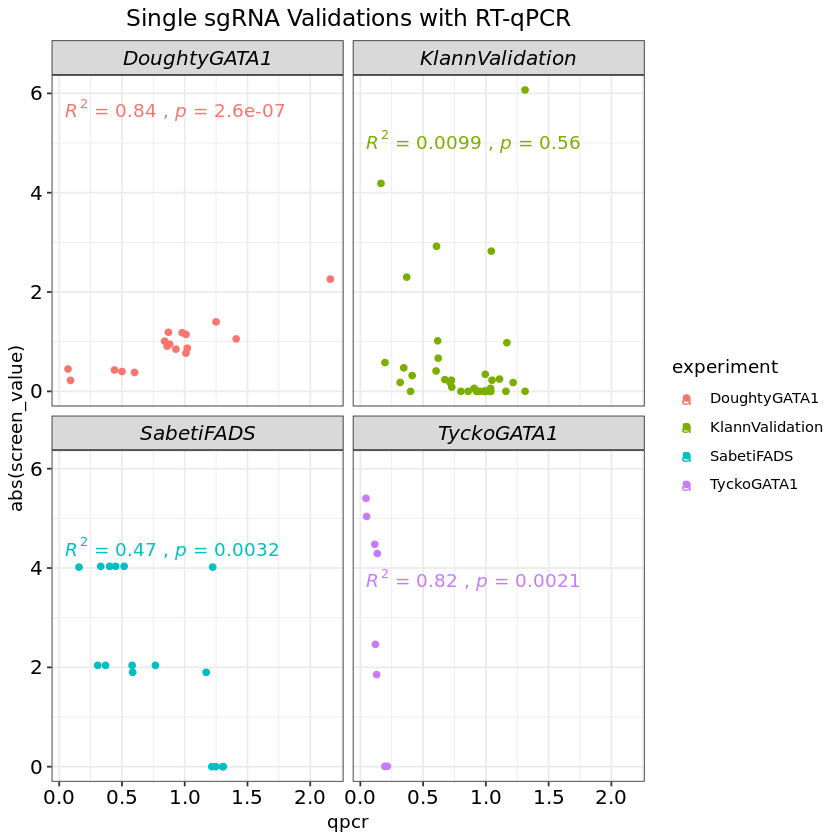

In [63]:
final_qpcr %>%
  # filter(qpcr_target == "GATA1" | qpcr_target == "LMO2" | qpcr_target == "FADS1") %>%
  mutate(experiment = ifelse(experiment == "DoughtyFF", "DoughtyGATA1", experiment)) %>%
  # filter(grna_type == "targeting" | grna_type == "TSS") %>%
  # filter(grna_type == "targeting") %>%
  ggplot(aes(x = qpcr, y = abs(screen_value), color = experiment)) +
  geom_point() +
  stat_cor(aes(label=paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x.npc = "left") +
  facet_wrap(~experiment) +
  ggtitle("Single sgRNA Validations with RT-qPCR") +
  theme_bw() +
  theme(axis.text = element_text(size = 12, color = "black"),
        plot.title = element_text(hjust = 0.5, color = "black", size = 14),
        strip.text = element_text(face = "italic", color = "black", size = 12)
        )

#### Filter genes, color by type of experiment (FF vs growth)

Warning message:
“Removed 3 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


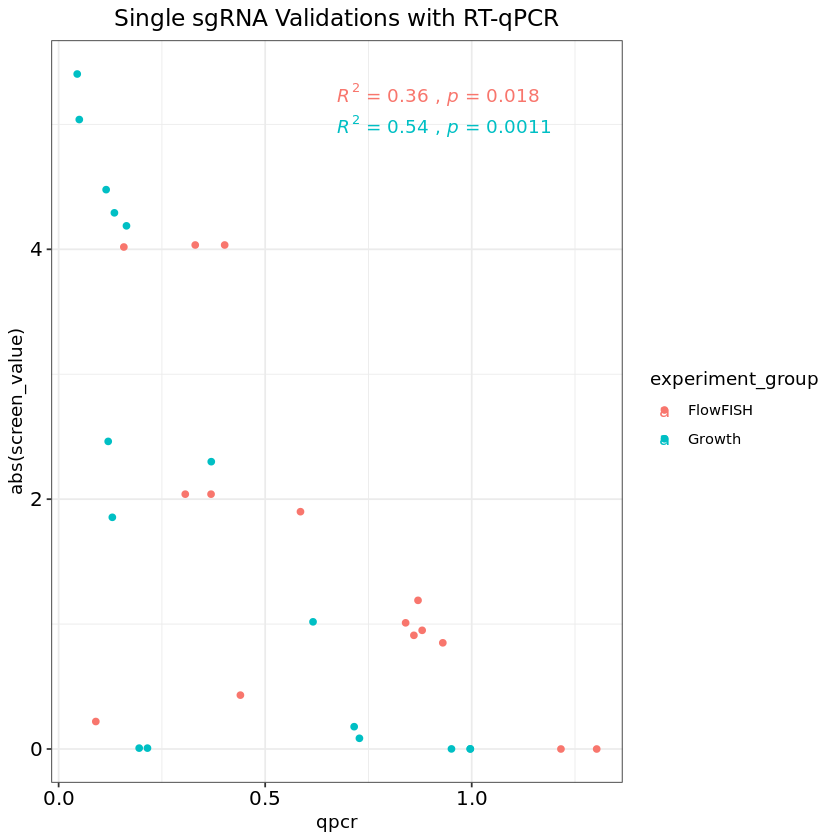

In [64]:
final_qpcr %>%
  filter(qpcr_target == "GATA1" | qpcr_target == "LMO2" | qpcr_target == "FADS1") %>%
  mutate(experiment_group = case_when(
    experiment == "SabetiFADS" | experiment == "DoughtyFF" ~ "FlowFISH",
    experiment == "KlannValidation" | experiment == "TyckoGATA1" ~ "Growth",
    TRUE ~ "wrong")
  ) %>%
  ggplot(aes(x = qpcr, y = abs(screen_value), color = experiment_group)) +
  geom_point() +
  stat_cor(aes(label=paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x.npc = "middle") +
  ggtitle("Single sgRNA Validations with RT-qPCR") +
  theme_bw() +
  theme(axis.text = element_text(size = 12, color = "black"),
        plot.title = element_text(hjust = 0.5, color = "black", size = 14)
        )

#### Manuscript group formatting:
Figure size = 183 mm X 247 mm Font: Arial, size 8 pt, regular style and not bold, italic, or underlined If absolutely necessary we can use some 6 pt font but it will look nice if everything is uniform at 8 point Figure axis title and axis labels should actually be the same size font (8 pt) instead of having a big title and tiny numbers on the axis Strokes: generally full black, always 0.5 pt width everywhere Colors: try to be consistent across figures, e.g. using colors that are in Fig 1 as a palette, and try to be colorblind friendly (avoid red and green on data). Keep dataset colors from fig 1 consistent throughout. Try to have high information density, less white space and more pixels used on the data (color/black) or text Font, stroke, resizing can be done in illustrator, but it helps to get the white space reduced while still generating the initial PDF/SVG vector for your panel (e.g. in python, prism) Don’t have axes extend far past where the actual data is If the trend is simple, the panel can take up ¼ of the page width, e.g. 45 mm If the data is more complex, the panel can take up a half or full page, 90 or 180 mm wide In general plotting programs default towards smaller point size and wider figure dimensions resulting in more white space, so you will probably want to compact the dimensions and increase point size before export Combine graphs when possible, or add additional information via shading, shapes, color, etc. high info density.
<br><br>
Add the R2 and p-values in Illustrator.

#### Use facet

Warning message:
“Removed 3 rows containing missing values (geom_point).”


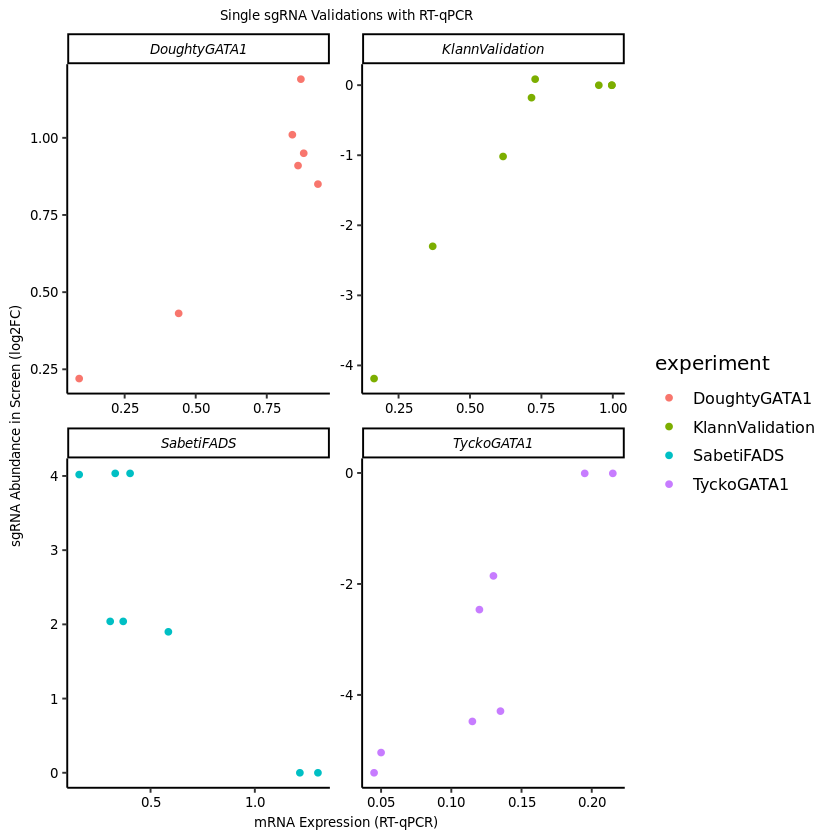

In [65]:
final_qpcr %>%
  filter(qpcr_target == "GATA1" | qpcr_target == "LMO2" | qpcr_target == "FADS1") %>%
  mutate(experiment = ifelse(experiment == "DoughtyFF", "DoughtyGATA1", experiment)) %>%
  # filter(grna_type == "targeting" | grna_type == "TSS") %>%
  # filter(grna_type == "targeting") %>%
  ggplot(aes(x = qpcr, y = screen_value, color = experiment)) +
  geom_point() +
  # stat_cor(aes(label=paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x.npc = "left") +
  facet_wrap(~experiment, scales = "free") +
  ggtitle("Single sgRNA Validations with RT-qPCR") +
  xlab("mRNA Expression (RT-qPCR)") +
  ylab("sgRNA Abundance in Screen (log2FC)") +
  theme_classic2() +
  theme(text = element_text(family = "sans"),
        axis.text = element_text(size = 8, color = "black"),
        axis.title = element_text(size = 8, color = "black"),
        plot.title = element_text(hjust = 0.5, color = "black", size = 8),
        strip.text = element_text(face = "italic", color = "black", size = 8)
        )

#### Stitch panels together instead

Warning message:
“Removed 3 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


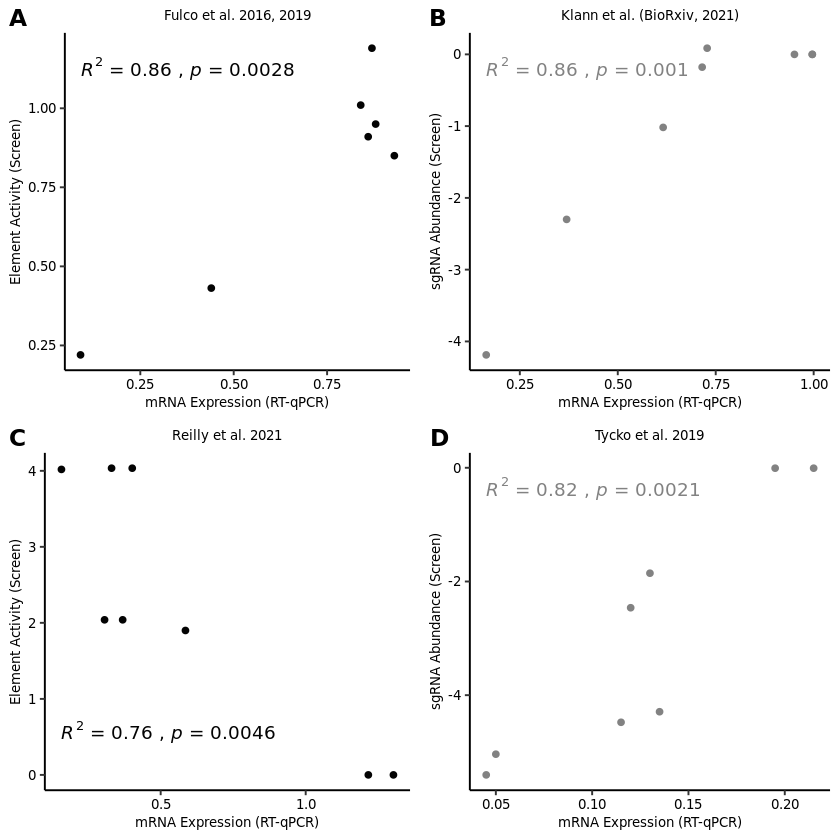

In [66]:
### growth screens colored in grey1
### FF screens in grey51
p1 <- final_qpcr %>%
  filter(qpcr_target == "GATA1" | qpcr_target == "LMO2" | qpcr_target == "FADS1") %>%
  mutate(experiment = ifelse(experiment == "DoughtyFF", "DoughtyGATA1", experiment)) %>%
  # filter(grna_type == "targeting" | grna_type == "TSS") %>%
  # filter(grna_type == "targeting") %>%
  filter(experiment == "DoughtyGATA1") %>%
  ggplot(aes(x = qpcr, y = screen_value, color = experiment)) + 
  scale_color_manual(values="grey1") +
  geom_point() +
  stat_cor(aes(label=paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x.npc = "left") +
  ggtitle("Fulco et al. 2016, 2019") +
  xlab("mRNA Expression (RT-qPCR)") +
  ylab("Element Activity (Screen)") +
  theme_classic2() +
  theme(text = element_text(family = "sans"),
        axis.text = element_text(size = 8, color = "black"),
        axis.title = element_text(size = 8, color = "black"),
        plot.title = element_text(hjust = 0.5, color = "black", size = 8),
        legend.position = "none"
        )

p2 <- final_qpcr %>%
  filter(qpcr_target == "GATA1" | qpcr_target == "LMO2" | qpcr_target == "FADS1") %>%
  mutate(experiment = ifelse(experiment == "DoughtyFF", "DoughtyGATA1", experiment)) %>%
  # filter(grna_type == "targeting" | grna_type == "TSS") %>%
  # filter(grna_type == "targeting") %>%
  filter(experiment == "KlannValidation") %>%
  ggplot(aes(x = qpcr, y = screen_value, color = experiment)) + 
  scale_color_manual(values="grey51") +
  geom_point() +
  stat_cor(aes(label=paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x.npc = "left") +
  ggtitle("Klann et al. (BioRxiv, 2021)") +
  xlab("mRNA Expression (RT-qPCR)") +
  ylab("sgRNA Abundance (Screen)") +
  theme_classic2() +
  theme(text = element_text(family = "sans"),
        axis.text = element_text(size = 8, color = "black"),
        axis.title = element_text(size = 8, color = "black"),
        plot.title = element_text(hjust = 0.5, color = "black", size = 8),
        legend.position = "none"
        )

p3 <- final_qpcr %>%
  filter(qpcr_target == "GATA1" | qpcr_target == "LMO2" | qpcr_target == "FADS1") %>%
  mutate(experiment = ifelse(experiment == "DoughtyFF", "DoughtyGATA1", experiment)) %>%
  # filter(grna_type == "targeting" | grna_type == "TSS") %>%
  # filter(grna_type == "targeting") %>%
  filter(experiment == "SabetiFADS") %>%
  ggplot(aes(x = qpcr, y = screen_value, color = experiment)) + 
  scale_color_manual(values="grey1") +
  geom_point() +
  stat_cor(aes(label=paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.y.npc = "bottom") +
  ggtitle("Reilly et al. 2021") +
  xlab("mRNA Expression (RT-qPCR)") +
  ylab("Element Activity (Screen)") +
  theme_classic2() +
  theme(text = element_text(family = "sans"),
        axis.text = element_text(size = 8, color = "black"),
        axis.title = element_text(size = 8, color = "black"),
        plot.title = element_text(hjust = 0.5, color = "black", size = 8),
        legend.position = "none"
        )

p4 <- final_qpcr %>%
  filter(qpcr_target == "GATA1" | qpcr_target == "LMO2" | qpcr_target == "FADS1") %>%
  mutate(experiment = ifelse(experiment == "DoughtyFF", "DoughtyGATA1", experiment)) %>%
  # filter(grna_type == "targeting" | grna_type == "TSS") %>%
  # filter(grna_type == "targeting") %>%
  filter(experiment == "TyckoGATA1") %>%
  ggplot(aes(x = qpcr, y = screen_value, color = experiment)) + 
  scale_color_manual(values="grey51") +
  geom_point() +
  stat_cor(aes(label=paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x.npc = "left") +
  ggtitle("Tycko et al. 2019") +
  xlab("mRNA Expression (RT-qPCR)") +
  ylab("sgRNA Abundance (Screen)") +
  theme_classic2() +
  theme(text = element_text(family = "sans"),
        axis.text = element_text(size = 8, color = "black"),
        axis.title = element_text(size = 8, color = "black"),
        plot.title = element_text(hjust = 0.5, color = "black", size = 8),
        legend.position = "none"
        )


finalplot <- ggarrange(p1,p2,p3,p4,
          labels = c("A","B","C","D"),
          ncol=2,
          nrow=2)

finalplot

In [67]:
pdf("suppfigure2/outs/supplementalfigure2.qpcrVsScreen.pdf")
print(finalplot)
dev.off()

png 
  2